# Word Embedding Analysis

In this file, I conduct an analysis based on the word embedding vectors of news headlines collected from the frontpages of 45 popular news media in the US, where each frontpage is scrapped every two hours. The data collection is still ongoing, and the analysis in this file is based on the headlines collect in January and February 2024.
The news media sites chose for data collection are based on<a href = "https://www.allsides.com/media-bias/ratings"> Allsides feature media list </a>.

 For initial analysis, I divide the news headlines into two clusters: left-leaning and right-leaning, where I then investigate alignment between the centroid of news headlines in each political group and wordnet antonym pairs dimensions. Preliminary result suggests that the political bias of right-leaning media well-aligned with wordnet dimensions, where they consistently associated Republican figures with positive dimension and Democratic figures with negative dimension. However, such trend is significantly weaker for left-leaning media.


## Load Data

load data from S3 bucket

In [1]:
import pandas as pd, numpy as np
from tqdm import tqdm

import json
from datetime import datetime

In [2]:
df_word_embedding = pd.read_parquet('./data/headlines/headlines_unique_Jan_Feb.parquet')
df_word_embedding

,url,headline,datePublished_site,probability,date_collected,siteName,NE,embedding
0,https://nypost.com/2024/01/23/lifestyle/couple...,Couple demanding child get free upgrade to fir...,None,0.892056,2024-01-23,NewYorkPost(News),[Coup],"[-0.037742957, -0.007708069, 0.004684645, -0.0..."
1,https://nypost.com/2024/01/23/entertainment/ka...,"Kate Middleton FaceTimes her kids George, Char...",None,0.892016,2024-01-23,NewYorkPost(News),"[Kate Middleton, George, Charlotte, Louis]","[-0.018179407, -0.0136436755, -0.017765962, -0..."
2,https://nypost.com/2024/01/23/entertainment/os...,2024 Oscar nominations announced: See the full...,None,0.903449,2024-01-23,NewYorkPost(News),[Oscar],"[-0.018472563, 0.031687282, -0.019757815, 0.00..."
3,https://nypost.com/2024/01/23/news/hunter-bide...,Hunter Biden's 'sugar brother' side steps ques...,None,0.922552,2024-01-23,NewYorkPost(News),"[Hunter Biden, Biden, Joe]","[0.043067176, 0.004102276, -0.020094428, 0.015..."
4,https://nypost.com/2024/01/23/lifestyle/a-bill...,A billionaire is paying my NYC rent for 3 mont...,None,0.907059,2024-01-23,NewYorkPost(News),[NYC],"[0.029510427, -0.03090462, -0.008285285, -0.01..."
...,...,...,...,...,...,...,...,...
267631,https://www.usatoday.com/story/news/world/2024...,New study says fish discovered 3 years ago can...,None,0.763477,2024-02-29,USATODAY,[],"[-0.019353423, -0.0029539436, -0.0129284, -0.0..."
267632,https://www.usatoday.com/story/entertainment/t...,"Black astronaut Ed Dwight, reflects on 'The Sp...",None,0.722521,2024-02-29,USATODAY,"[Black, Ed Dwight, The, Space Race]","[-0.00038863573, -0.021946488, -0.021370115, -..."
267633,https://www.usatoday.com/story/news/nation/202...,"'Life-threatening' conditions, up to 10 feet o...",None,0.685995,2024-02-29,USATODAY,[],"[-0.01681874, -0.009240714, -0.002482043, 0.02..."
267634,https://www.usatoday.com/videos/news/politics/...,"Biden, Trump visit US-Mexico border on same day",None,0.448134,2024-02-29,USATODAY,"[Biden, Trump, US, Mexico]","[0.017860102, 0.00048904907, -0.012666605, -0...."


In [4]:
file_path = './data/site_leanings.json'

# Loading the JSON content
with open(file_path, 'r') as file:
    left_or_right = json.load(file)

In [5]:
tqdm.pandas()
df_word_embedding["leaning"] = df_word_embedding.progress_apply(lambda x : left_or_right[x["siteName"]], axis = 1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 267636/267636 [00:03<00:00, 82261.15it/s]


In [6]:
df_word_embedding.memory_usage(deep=True).sum() / (1024 ** 2)

188.62172889709473

In [8]:
df_word_embedding.head(5)

,url,headline,datePublished_site,probability,date_collected,siteName,NE,embedding,leaning
0,https://nypost.com/2024/01/23/lifestyle/couple...,Couple demanding child get free upgrade to fir...,None,0.892056,2024-01-23,NewYorkPost(News),[Coup],"[-0.037742957, -0.007708069, 0.004684645, -0.0...",right
1,https://nypost.com/2024/01/23/entertainment/ka...,"Kate Middleton FaceTimes her kids George, Char...",None,0.892016,2024-01-23,NewYorkPost(News),"[Kate Middleton, George, Charlotte, Louis]","[-0.018179407, -0.0136436755, -0.017765962, -0...",right
2,https://nypost.com/2024/01/23/entertainment/os...,2024 Oscar nominations announced: See the full...,None,0.903449,2024-01-23,NewYorkPost(News),[Oscar],"[-0.018472563, 0.031687282, -0.019757815, 0.00...",right
3,https://nypost.com/2024/01/23/news/hunter-bide...,Hunter Biden's 'sugar brother' side steps ques...,None,0.922552,2024-01-23,NewYorkPost(News),"[Hunter Biden, Biden, Joe]","[0.043067176, 0.004102276, -0.020094428, 0.015...",right
4,https://nypost.com/2024/01/23/lifestyle/a-bill...,A billionaire is paying my NYC rent for 3 mont...,None,0.907059,2024-01-23,NewYorkPost(News),[NYC],"[0.029510427, -0.03090462, -0.008285285, -0.01...",right


## Construct Good/bad Antonyms

In this part, I construct a positive vs negative dimension using the keywords from <a href="https://journals.sagepub.com/doi/full/10.1177/0003122419877135" style="color: blue;">a previous research </a>. The dimension is defined as the vector between the centroid of word embedding vectors of positive words and the embedding vectors of negative words. The embedding vectors is from openAI’s text-embedding-3-large model. 

In [10]:
# read data
df_good_bad = pd.read_parquet("./data/df_good_bad.parquet")

In [11]:
df_good_bad

,good_word,good_embedding,bad_word,bad_embedding
0,good,"[0.004305769689381123, -0.004893989767879248, ...",bad,"[-0.014306066557765007, 0.009409538470208645, ..."
1,best,"[0.008746912702918053, 0.03367193415760994, -0...",worst,"[-0.022390739992260933, 0.035692859441041946, ..."
2,fine,"[-0.0010375342098996043, 0.0039906795136630535...",deficient,"[0.016590019688010216, 0.03946790471673012, -0..."
3,superior,"[0.02638305351138115, 0.004405620042234659, -0...",inferior,"[-0.017175743356347084, 0.0025245025753974915,..."
4,satisfactory,"[0.028946034610271454, 0.037752605974674225, -...",unsatisfactory,"[0.028165165334939957, 0.017635727301239967, -..."
5,acceptable,"[-0.004314293619245291, 0.03673477843403816, -...",unacceptable,"[-0.00701149133965373, -0.01975487731397152, -..."
6,excellent,"[-0.0028321566060185432, 0.009339209645986557,...",awful,"[-0.026952287182211876, -0.0062140957452356815..."
7,superb,"[0.05479724332690239, 0.016285769641399384, -0...",terrible,"[-0.02064591273665428, -0.002998895011842251, ..."
8,outstanding,"[0.018081525340676308, 0.02422449178993702, -0...",dreadful,"[-0.009716781787574291, 0.010948600247502327, ..."
9,exceptional,"[0.00447204289957881, 0.02894514426589012, -0....",unexceptional,"[0.001000346033833921, 0.01961054652929306, -0..."


In [12]:
good_bad_dimension = np.mean(df_good_bad["good_embedding"]) - np.mean(df_good_bad["bad_embedding"])

In [13]:
# this is the constructed vector
good_bad_dimension

array([ 0.02099921,  0.00841344, -0.0051291 , ..., -0.00711416,
       -0.00103793,  0.00046543])

## News Headlines and Dimensions Comparison

For this part, I conducted three tests for different subsets of the headlines to compare the alignment between headline centroid and the dimensions. For each test, I first compare the centroid a dimension based on Wordnet’s antonym pair by cosine similarity, and I then compare the dimension to the pre-constructed good-bad dimensions. In this way, I can understand 1. What are the best dimensions to describe the difference between the difference between the headlines in left-leaning and right-leaning media; 2. How well this dimension aligns with the good-vs-bad dimension (in other words, can we simplify the political of news media to praising of one ‘own stance and attacking the opposite stance)?

### Load antonyms

In [ ]:
from util import *
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

In [16]:
df_antonyms = pd.read_parquet("data/df_antonyms.parquet")
df_antonyms

,adj_1,adj_2,adj_1_embedding,adj_2_embedding
0,comparable,incomparable,"[-0.019301222637295723, 0.011061019264161587, ...","[0.012978984974324703, -0.0027543564792722464,..."
1,proved,unproved,"[0.016204241663217545, 0.016003673896193504, -...","[0.015760842710733414, 0.0006610580021515489, ..."
2,fatty,nonfat,"[-0.006109761074185371, 0.018375856801867485, ...","[-0.0030756292399019003, 0.006370946299284697,..."
3,disposable,nondisposable,"[-0.06539838016033173, 0.002771256258711219, 0...","[-0.046912819147109985, -0.0005513812648132443..."
4,shrinkable,unshrinkable,"[-0.019847901538014412, -0.008843732997775078,...","[-0.001083246199414134, -0.022068507969379425,..."
...,...,...,...,...
1823,appealing,unappealing,"[-0.00962099339812994, 0.022533150389790535, -...","[-0.006122448015958071, -0.01592993177473545, ..."
1824,precocious,retarded,"[0.009357798844575882, 0.02012326754629612, -0...","[-0.008591502904891968, 0.004101067315787077, ..."
1825,breathing,breathless,"[-0.0037388750351965427, 0.01762058027088642, ...","[0.004579761065542698, 0.022734813392162323, 0..."
1826,analogue,digital,"[-0.026716582477092743, -0.009638152085244656,...","[-0.01176784373819828, 0.012267342768609524, -..."


### Compare between left and right media, all headlines included

In this section, I first compare centroid of the all headlines from left-leaning and right-leaning media to the Wordnet dimensions, and I then compare these Wordnet dimensions to the good-vs-bad dimension. The result suggests that best aligning dimensions seem to  be arbitrary, and not well aligned with good-vs-bad dimension. This is the expected result, as the political bias is likely to be partisan: rather than all headlines in a news media front page appear to share the similar sentiment, the sentiment and framing is specific to political figures with certain leanings, based on the news media’s own leaning (for example, right-leaning media probably describe Biden more negatively, rather than describing everything negative).  

In [17]:
def get_left_to_right_vec(df):
    centroids = {}
    for group_name, group_df in df.groupby('leaning'):
        # Drop the 'group' column to only include embedding dimensions
        group_df = group_df.drop('leaning', axis=1)
        
        # Calculate centroid for the current group
        centroid = cluster_centroid(group_df["embedding"])
        
        # Store the centroid using the group name as the key
        centroids[group_name] = centroid

    left_to_right_vec = centroids["right"] - centroids["left"]
    return left_to_right_vec

def calc_scale_leaning_similarity_df(df_word_embedding, df_antonyms, good_bad_dimension):
    left_to_right_vec = get_left_to_right_vec(df_word_embedding)
    result = []
    for x in df_antonyms.apply(lambda x : [x["adj_1"], x["adj_2"], get_cos_similiarity(x["adj_1_embedding"] - x["adj_2_embedding"], left_to_right_vec), \
                                           abs(get_cos_similiarity(x["adj_1_embedding"] - x["adj_2_embedding"], good_bad_dimension))], axis = 1):
        # left adj, right_adj, dimension similarity to the distance between right and left, dimension similarity to good/bad dimension
        if x[2] > 0:
            # reverese the order according to the direction of the dimension
            result.append([x[1], x[0], abs(x[2]), x[3]])
        else:
            result.append([x[0], x[1], abs(x[2]), x[3]])
    

    return pd.DataFrame(result, columns = ["Left_adj", "Right_adj", "scale_leaning_similarity", "scale_good_bad_similiarity"])

In [19]:
# no general pattern
df_left_right_result = calc_scale_leaning_similarity_df(df_word_embedding, df_antonyms, good_bad_dimension).sort_values(by='scale_leaning_similarity', ascending=False)
df_left_right_result.head(30)[["Left_adj", "Right_adj"]]

,Left_adj,Right_adj
1246,topped,topless
74,unexploited,exploited
505,nonalcoholic,alcoholic
603,modest,immodest
283,concentric,eccentric
103,nonwoody,woody
515,publishable,unpublishable
812,bloodless,bloody
917,orderly,disorderly
393,forehand,backhand


The dimensions that align the best with the difference, where Left_adj refers to the adjective aligns with the left-leaning media and right_adj refers to the adjective aligns with the right-leaning media, considering all headlines. These dimensions seem to be difficult to interpret.

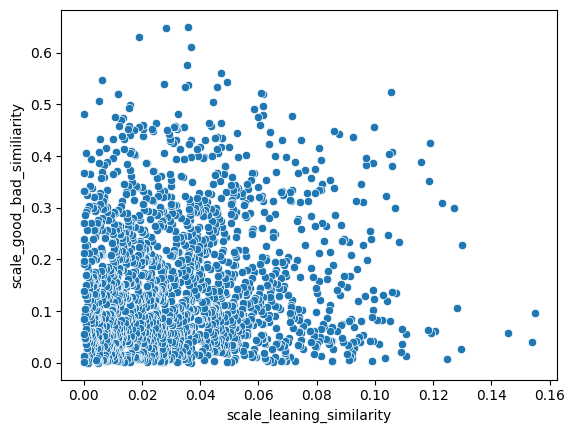

In [24]:
# Plotting
sns.scatterplot(data=df_left_right_result, x='scale_leaning_similarity', y='scale_good_bad_similiarity')

# Display the plot
plt.show()

The graph that plots the dimensions similarity to headlines against the dimensions similarity to the good-vs-bad dimensions.

In [27]:
# Calculate Spearman's rank correlation
rho, p_value = spearmanr(df_left_right_result['scale_good_bad_similiarity'], df_left_right_result['scale_leaning_similarity'])

print(f"Spearman's rank correlation coefficient: {rho}")
print(f"P-value: {p_value}")


Spearman's rank correlation coefficient: 0.03370445966865227
P-value: 0.14973683413810995


I also performed a Spearman's R test to examine whether the dimension aligns well with the difference between news headlines also aligns well with the good-vs-bad dimension. The result and the graph suggests that alignment is poor.

### Comparision between Biden and Trump related Terms

In this section, I only consider headlines regarding Joe Biden and Donald Trump. The procedure is same as before, where I first compare centroid of the headlines from left-leaning and right-leaning media to the Wordnet dimensions. The result suggests bias agianst Biden is salient and aligns well with the good-vs-bad dimension. However, the bias against Trump is more difficult to interpret.  

In [29]:
def filter_df_by_NE(df, NE):
    # filiter df to include rows with at least one named entity in the list NE
    filtered_df = df[df['NE'].apply(lambda x: len(set(x) & set(NE)) > 0)]
    return filtered_df

df_biden = filter_df_by_NE(df_word_embedding, ["Biden", "Joe Biden"])
df_biden_result = calc_scale_leaning_similarity_df(df_biden, df_antonyms, good_bad_dimension).sort_values(by='scale_leaning_similarity', ascending=False)

In [31]:
df_biden_result.head(10)

,Left_adj,Right_adj,scale_leaning_similarity,scale_good_bad_similiarity
264,supportive,unsupportive,0.217544,0.449561
80,hopeful,hopeless,0.200252,0.357643
323,employable,unemployable,0.196274,0.388458
1717,respectful,disrespectful,0.194835,0.408849
880,tactful,tactless,0.193843,0.404128
991,seaworthy,unseaworthy,0.190906,0.523857
1483,considerate,inconsiderate,0.187947,0.382445
1627,playable,unplayable,0.185498,0.417247
1707,pro-American,anti-American,0.184464,0.354263
603,modest,immodest,0.183473,0.228343


The dimensions that align the best with the difference of Biden-related headlines, where Left_adj refers to the adjective aligns with the left-leaning media and right_adj refers to the adjective aligns with the right-leaning media.

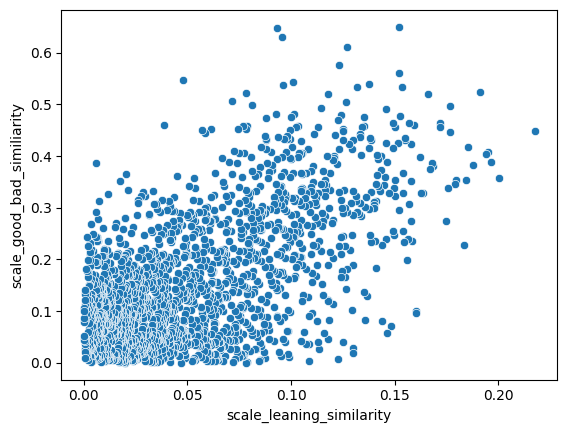

In [32]:
# Plotting
sns.scatterplot(data=df_biden_result, x='scale_leaning_similarity', y='scale_good_bad_similiarity')

# Display the plot
plt.show()

In [34]:
# Spearman's rank
rho, p_value = spearmanr(df_biden_result['scale_good_bad_similiarity'], df_biden_result['scale_leaning_similarity'])

print(f"Spearman's rank correlation coefficient: {rho}")
print(f"P-value: {p_value}")

Spearman's rank correlation coefficient: 0.48989143421026077
P-value: 5.8401093758799966e-111


The graph and Spearman's rank correlation coefficient all indictes a signficant level of bias on the good-vs-bad dimension.

In [37]:
# Trump result
df_trump = filter_df_by_NE(df_word_embedding, ["Trump", "Donald Trump"])
df_trump_result = calc_scale_leaning_similarity_df(df_trump, df_antonyms, good_bad_dimension).sort_values(by='scale_leaning_similarity', ascending=False)
df_trump_result.head(10)

,Left_adj,Right_adj,scale_leaning_similarity,scale_good_bad_similiarity
835,substantive,adjective,0.149455,0.042361
1024,stoppable,unstoppable,0.120541,0.011126
971,unowned,owned,0.118999,0.168544
625,nonbearing,bearing,0.113781,0.148135
94,hearing,deaf,0.111707,0.129156
873,endothermic,exothermic,0.110599,0.004128
1581,unobvious,obvious,0.110554,0.041473
1621,atomistic,holistic,0.110260,0.079702
1443,unmade,made,0.107712,0.213323
1289,uncoated,coated,0.104946,0.167304


The dimensions that align the best with the difference of Trump-related headlines, where Left_adj refers to the adjective aligns with the left-leaning media and right_adj refers to the adjective aligns with the right-leaning media. As you can see, the dimension seem to be more arbitrary.

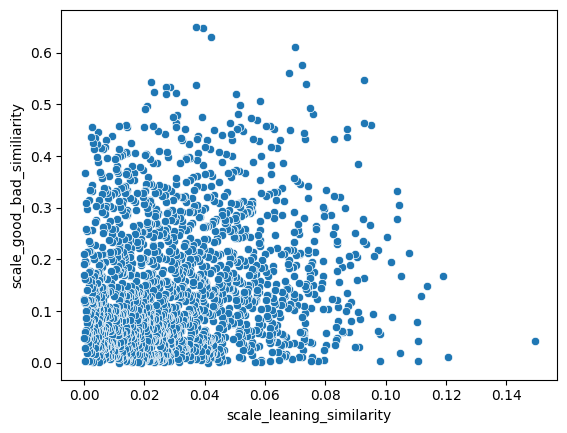

In [38]:
# Plotting
sns.scatterplot(data=df_trump_result, x='scale_leaning_similarity', y='scale_good_bad_similiarity')

# Display the plot
plt.show()

In [39]:
# Spearman's rank
rho, p_value = spearmanr(df_trump_result['scale_good_bad_similiarity'], df_trump_result['scale_leaning_similarity'])

print(f"Spearman's rank correlation coefficient: {rho}")
print(f"P-value: {p_value}")

Spearman's rank correlation coefficient: 0.11228457124722419
P-value: 1.4891788929819712e-06


The graph and Spearman's rank correlation coefficient also indictes a lower level of bias on the good-vs-bad dimension.

### Comparision between Democrats and Republican related Terms

In this section, I  consider regarding Republican and Democratic figures, using the name classifier build before. The procedure is same as before, where I first compare centroid of the headlines from left-leaning and right-leaning media to the Wordnet dimensions. The result suggests bias against Democratic figures is salient and aligns well with the good-vs-bad dimension. However, the bias against Republican is more difficult to interpret. The result suggests that overall bias is more salient toward Democrats, for both presidential candidates and other figures.

In [40]:
file_path = './data/dem_rep_NEs.json'

with open(file_path, 'r') as file:
    dem_or_rep = json.load(file)

In [41]:
df_dem = filter_df_by_NE(df_word_embedding,dem_or_rep["Dem"])
df_dem_result = calc_scale_leaning_similarity_df(df_dem, df_antonyms, good_bad_dimension).sort_values(by='scale_leaning_similarity', ascending=False)
df_dem_result.head(10)

,Left_adj,Right_adj,scale_leaning_similarity,scale_good_bad_similiarity
264,supportive,unsupportive,0.183994,0.449561
80,hopeful,hopeless,0.180730,0.357643
603,modest,immodest,0.173465,0.228343
1717,respectful,disrespectful,0.172078,0.408849
323,employable,unemployable,0.170934,0.388458
880,tactful,tactless,0.165690,0.404128
991,seaworthy,unseaworthy,0.165169,0.523857
463,grateful,ungrateful,0.158162,0.352828
1726,respectable,unrespectable,0.158034,0.456394
1459,constructive,destructive,0.158027,0.274039


The dimension best aligns with Democratic figures related headlines.

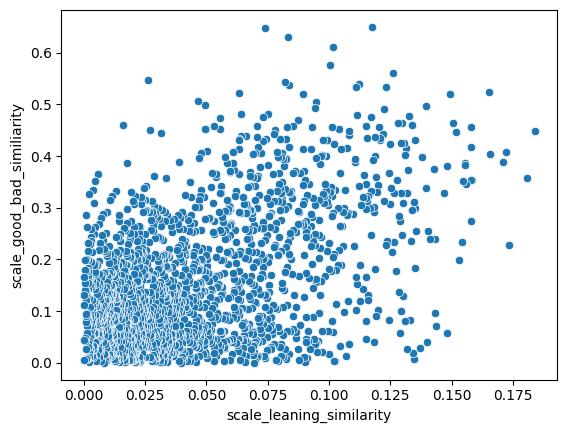

In [42]:
# Plotting
sns.scatterplot(data=df_dem_result, x='scale_leaning_similarity', y='scale_good_bad_similiarity')

# Display the plot
plt.show()

In [43]:
# Spearman's rank
rho, p_value = spearmanr(df_dem_result['scale_good_bad_similiarity'], df_dem_result['scale_leaning_similarity'])

print(f"Spearman's rank correlation coefficient: {rho}")
print(f"P-value: {p_value}")

Spearman's rank correlation coefficient: 0.3681301433733732
P-value: 9.140846920178839e-60


The result indicates the top dimension also aligns well with the good-vs-bad dimension.

In [45]:
df_rep = filter_df_by_NE(df_word_embedding,dem_or_rep["Rep"])
df_rep_result = calc_scale_leaning_similarity_df(df_rep, df_antonyms, good_bad_dimension).sort_values(by='scale_leaning_similarity', ascending=False)
df_rep_result.head(30)

,Left_adj,Right_adj,scale_leaning_similarity,scale_good_bad_similiarity
835,substantive,adjective,0.155476,0.042361
625,nonbearing,bearing,0.124878,0.148135
1812,nonrepresentative,representative,0.122779,0.278826
971,unowned,owned,0.122348,0.168544
1621,atomistic,holistic,0.120176,0.079702
1581,unobvious,obvious,0.118718,0.041473
1748,nonpartisan,partisan,0.115757,0.088050
1289,uncoated,coated,0.115633,0.167304
1024,stoppable,unstoppable,0.115499,0.011126
1443,unmade,made,0.115161,0.213323


The dimension best aligns with Republican figures related headlines.

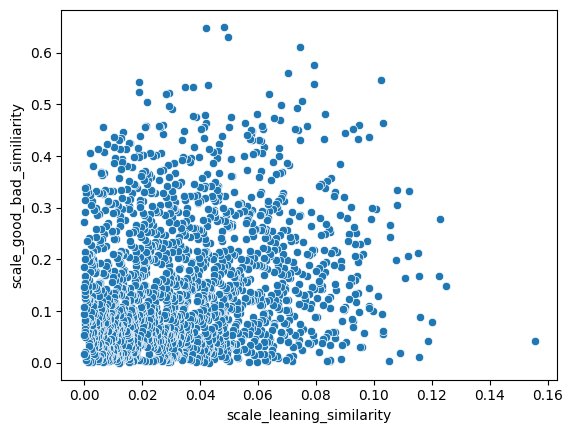

In [46]:
# Plotting
sns.scatterplot(data=df_rep_result, x='scale_leaning_similarity', y='scale_good_bad_similiarity')

# Display the plot
plt.show()

In [48]:
# Spearman's rank
rho, p_value = spearmanr(df_rep_result['scale_good_bad_similiarity'], df_rep_result['scale_leaning_similarity'])

print(f"Spearman's rank correlation coefficient: {rho}")
print(f"P-value: {p_value}")

Spearman's rank correlation coefficient: 0.15649695963521154
P-value: 1.7205447304725166e-11


Spearman's rank correlation and p value to determine if top dimension aligns well with the good-vs-bad dimension. The result suggests that the alignment is much weaker.

## Other Exploratory Analysis

Here, I also explore the headlines regarding Nikki Haley and Jean Carroll, who are trending figures during the time of data collection. The result suggests that embedding dimension can also capture the news topics, where headlines regarding Nikki Haley focus more on finished-vs-unfinished (likely regarding her presidential campaign bet). Similarity, headlines regarding Jean Carroll is more about whether she is legitimated or not (likely regarding her litigation with Trump).

In [43]:
Haley_NEs = ["Haley", "Nikki Haley"]

df_Haley = filter_df_by_NE(df_word_embedding, Haley_NEs)
df_Haley = sample_n_from_group(df_Haley, 100)
calc_scale_leaning_similarity_df(df_Haley, df_antonyms).sort_values(by='scale_leaning_similarity', ascending=False).head(30)

/tmp/ipykernel_106178/1785357269.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('leaning').apply(lambda x : x.sample(n=n_samples, replace=True)).reset_index(drop=True)


,Left_adj,Right_adj,scale_leaning_similarity
452,unfortunate,fortunate,0.127046
841,undeclared,declared,0.126955
687,unfinished,finished,0.125646
1581,unobvious,obvious,0.120649
955,inglorious,glorious,0.116648
1692,unsolved,solved,0.107224
853,subordinate,dominant,0.106990
1797,sorrowful,joyful,0.106091
1535,stingy,generous,0.104472
1113,unfilled,filled,0.103055


In [44]:
Carroll_NEs = ["Carroll", "Jean Carroll"]

df_Carroll = filter_df_by_NE(df_word_embedding, Carroll_NEs)
df_Carroll = sample_n_from_group(df_Carroll, 100)
calc_scale_leaning_similarity_df(df_Carroll, df_antonyms).sort_values(by='scale_leaning_similarity', ascending=False).head(30)

/tmp/ipykernel_106178/1785357269.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('leaning').apply(lambda x : x.sample(n=n_samples, replace=True)).reset_index(drop=True)


,Left_adj,Right_adj,scale_leaning_similarity
885,unargumentative,argumentative,0.143411
1781,diffident,confident,0.141213
432,unexpansive,expansive,0.137762
579,noneffervescent,effervescent,0.121835
539,unexcited,excited,0.116494
891,unendowed,endowed,0.114275
889,provincial,cosmopolitan,0.113915
380,unenthusiastic,enthusiastic,0.113792
239,inconspicuous,conspicuous,0.111089
1490,unrigged,rigged,0.106709
